<a href="https://colab.research.google.com/github/AminaIskandarani/EECE690-Project/blob/main/RandomForest_realdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Mount Drive (if in Colab) ---
from google.colab import drive
drive.mount('/content/drive')

# --- Install dependencies (only needed once) ---
# !pip install pandas openpyxl tqdm scikit-learn matplotlib

# --- 1. Load Libraries ---
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# --- 2. Load Your Files ---
healthy_data_path = '/content/drive/MyDrive/ahmad dataset4.5.25/turbine_T01_data.csv'
real_fault_data_path = '/content/drive/MyDrive/ahmad dataset4.5.25/failure_only_sensor_data_with_failure_info (1).csv'

healthy_data = pd.read_csv(healthy_data_path)
real_fault_data = pd.read_csv(real_fault_data_path)

Mounted at /content/drive


Injecting synthetic faults based on real Remarks...


100%|██████████| 21270/21270 [01:11<00:00, 295.57it/s]


✅ Done! Synthetic faulty turbine dataset saved to: /content/synthetic_faulty_turbine_data.csv

🎯 Classification Report:
                                                                    precision    recall  f1-score   support

                               Electric circuit error in generator       1.00      1.00      1.00       275
                                         Error in pitch regulation       0.99      1.00      1.00       252
                                          Gearbox bearings damaged       1.00      0.99      1.00       256
                                              Gearbox pump damaged       1.00      1.00      1.00       242
                                        Generator bearings damaged       1.00      1.00      1.00       275
                                                 Generator damaged       1.00      1.00      1.00       283
                                                Generator replaced       1.00      0.99      0.99       270
               

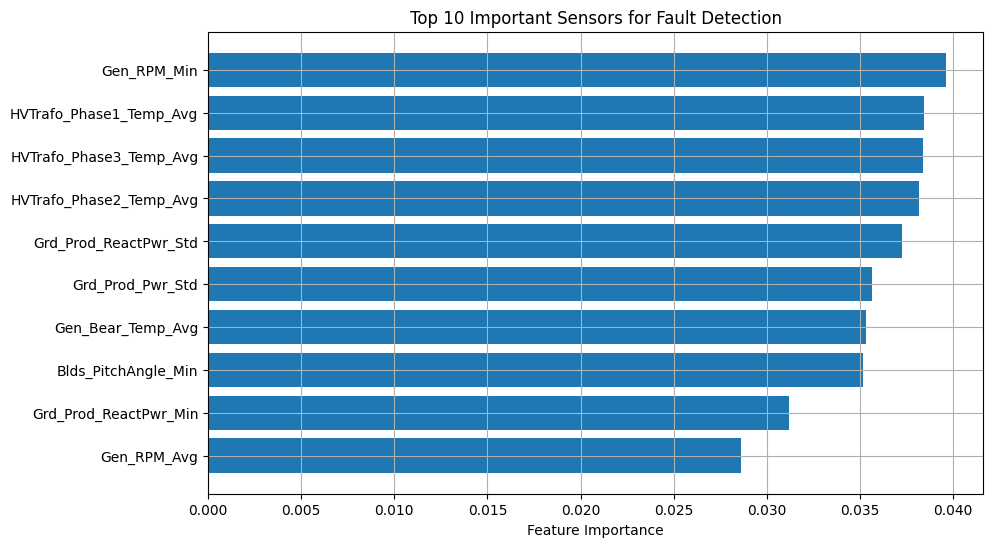

In [2]:


# --- PATCH 1: Force healthy data to float64 ---
healthy_data = healthy_data.apply(lambda col: col.astype(float) if np.issubdtype(col.dtype, np.number) else col)

# --- 3. Prepare the Real Fault Behavior by Remarks ---
cols_to_ignore = ['Component'] if 'Component' in real_fault_data.columns else []
real_fault_data = real_fault_data.drop(columns=[col for col in cols_to_ignore if col in real_fault_data.columns], errors='ignore')

common_columns = list(set(healthy_data.columns).intersection(set(real_fault_data.columns)))
healthy_data = healthy_data[common_columns]
real_fault_data = real_fault_data[common_columns + ['Remarks']]

remark_patterns = {}
remarks_list = real_fault_data['Remarks'].unique().tolist()

for remark in remarks_list:
    subset = real_fault_data[real_fault_data['Remarks'] == remark].drop(columns=['Remarks'])
    if not subset.empty:
        subset_numeric = subset.select_dtypes(include=[np.number])
        mean_faulty = subset_numeric.mean()
        mean_normal = healthy_data.select_dtypes(include=[np.number]).mean()
        diff_percent = 100 * (mean_faulty - mean_normal) / mean_normal
        significant_sensors = diff_percent[abs(diff_percent) >= 10].index.tolist()
        pattern = {sensor: diff_percent[sensor] for sensor in significant_sensors}
        remark_patterns[remark] = pattern

# --- 4. Inject Synthetic Faults ---
synthetic_data = healthy_data.copy()
n_total = len(synthetic_data)
n_faults = random.randint(int(0.20 * n_total), int(0.25 * n_total))

fault_rows = random.sample(range(n_total), n_faults)
fault_remarks_per_row = random.choices(remarks_list, k=n_faults)

synthetic_data['Fault_Flag'] = 0
synthetic_data['Remarks'] = None

# --- PATCH 2: Force synthetic data to float64 before injection ---
synthetic_data = synthetic_data.apply(lambda col: col.astype(float) if np.issubdtype(col.dtype, np.number) else col)

print("Injecting synthetic faults based on real Remarks...")

for idx, remark in tqdm(zip(fault_rows, fault_remarks_per_row), total=n_faults):
    fault_pattern = remark_patterns.get(remark, {})
    for sensor, shift_percent in fault_pattern.items():
        if sensor in synthetic_data.columns:
            synthetic_data.at[idx, sensor] = synthetic_data.at[idx, sensor] * (1 + shift_percent / 100.0)
    synthetic_data.at[idx, 'Fault_Flag'] = 1
    synthetic_data.at[idx, 'Remarks'] = remark

# --- 5. Save the Synthetic Dataset ---
output_path = '/content/synthetic_faulty_turbine_data.csv'
synthetic_data.to_csv(output_path, index=False)
print(f"✅ Done! Synthetic faulty turbine dataset saved to: {output_path}")

# --- 6. Load the Synthetic Data for Training ---
data = pd.read_csv(output_path)

# --- PATCH 3: Clean dataset (drop missing Remarks, force float again) ---
data = data.dropna(subset=['Remarks'])
data = data.apply(lambda col: col.astype(float) if np.issubdtype(col.dtype, np.number) else col)

# --- 7. Prepare Features and Labels ---
X = data.drop(columns=['Fault_Flag', 'Remarks'])
X = X.select_dtypes(include=[np.number])

y = data['Remarks']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# --- 8. Build and Train Random Forest ---
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

# --- 9. Predict and Evaluate ---
y_pred = rf_model.predict(X_test)

print("\n🎯 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

overall_accuracy = accuracy_score(y_test, y_pred)
print(f'\n✅ Overall Accuracy: {overall_accuracy * 100:.2f}%')
print(f'✔ Correct Predictions: {np.sum(y_test == y_pred)} / {len(y_test)}')

# --- 10. Feature Importance Plot (Optional) ---
importances = rf_model.feature_importances_
feature_names = X.columns

importance_table = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_table = importance_table.sort_values(by='Importance', ascending=False)

# Plot Top 10 Features
plt.figure(figsize=(10,6))
plt.barh(importance_table['Feature'].head(10), importance_table['Importance'].head(10))
plt.gca().invert_yaxis()
plt.title('Top 10 Important Sensors for Fault Detection')
plt.xlabel('Feature Importance')
plt.grid(True)
plt.show()


In [12]:
overlapping_pairs = [
    ("High temperature in generator", "Generator bearing temperature (replaced sensor)"),
    ("Transformer damaged", "Transformer temperature sensor failure"),
    ("Hydraulic oil temp high", "Gearbox pump damaged"),
]


In [15]:
import numpy as np
from tqdm import tqdm

# Define similar pairs that should generate overlapping faults
overlapping_pairs = [
    ("High temperature in generator", "Generator bearing temperature (replaced sensor)"),
    ("Transformer damaged", "Transformer temperature sensor failure"),
    ("Hydraulic oil temp high", "Gearbox pump damaged"),
]

# Helper to merge patterns
def merge_patterns(p1, p2, alpha=0.5):
    all_keys = set(p1.keys()).union(p2.keys())
    return {
        k: alpha * p1.get(k, 0) + (1 - alpha) * p2.get(k, 0)
        for k in all_keys
    }

# Start synthetic data creation
synthetic_data = healthy_data.copy()
n_total = len(synthetic_data)
n_faults = random.randint(int(0.20 * n_total), int(0.25 * n_total))
fault_rows = random.sample(range(n_total), n_faults)

synthetic_data['Fault_Flag'] = 0
synthetic_data['Remarks'] = None

print("Injecting overlapping faults with Gaussian noise...")

for idx in tqdm(fault_rows):
    use_overlap = random.random() < 0.3  # 30% of faults are overlapping
    if use_overlap:
        pair = random.choice(overlapping_pairs)
        p1 = remark_patterns.get(pair[0], {})
        p2 = remark_patterns.get(pair[1], {})
        mixed_pattern = merge_patterns(p1, p2, alpha=random.uniform(0.4, 0.6))
        label = f"{pair[0]} + {pair[1]}"
    else:
        label = random.choice(remarks_list)
        mixed_pattern = remark_patterns.get(label, {})

    for sensor, shift_percent in mixed_pattern.items():
        if sensor in synthetic_data.columns:
            # Add Gaussian noise (mean 0, std 10%)
            noise = np.random.normal(loc=0, scale=0.1)
            multiplier = 1 + shift_percent / 100.0 + noise
            synthetic_data.at[idx, sensor] *= multiplier

    synthetic_data.at[idx, 'Fault_Flag'] = 1
    synthetic_data.at[idx, 'Remarks'] = label


Injecting overlapping faults with Gaussian noise...


100%|██████████| 24274/24274 [01:17<00:00, 314.00it/s]



📊 Classification Report:
                                                                                 precision    recall  f1-score   support

                                            Electric circuit error in generator       0.99      1.00      1.00       188
                                                      Error in pitch regulation       1.00      1.00      1.00       225
                                                       Gearbox bearings damaged       1.00      0.97      0.98       229
                                                           Gearbox pump damaged       0.98      1.00      0.99       228
                                                     Generator bearings damaged       0.99      1.00      0.99       208
                                                              Generator damaged       0.98      0.99      0.98       223
                                                             Generator replaced       0.95      0.97      0.96       195
     

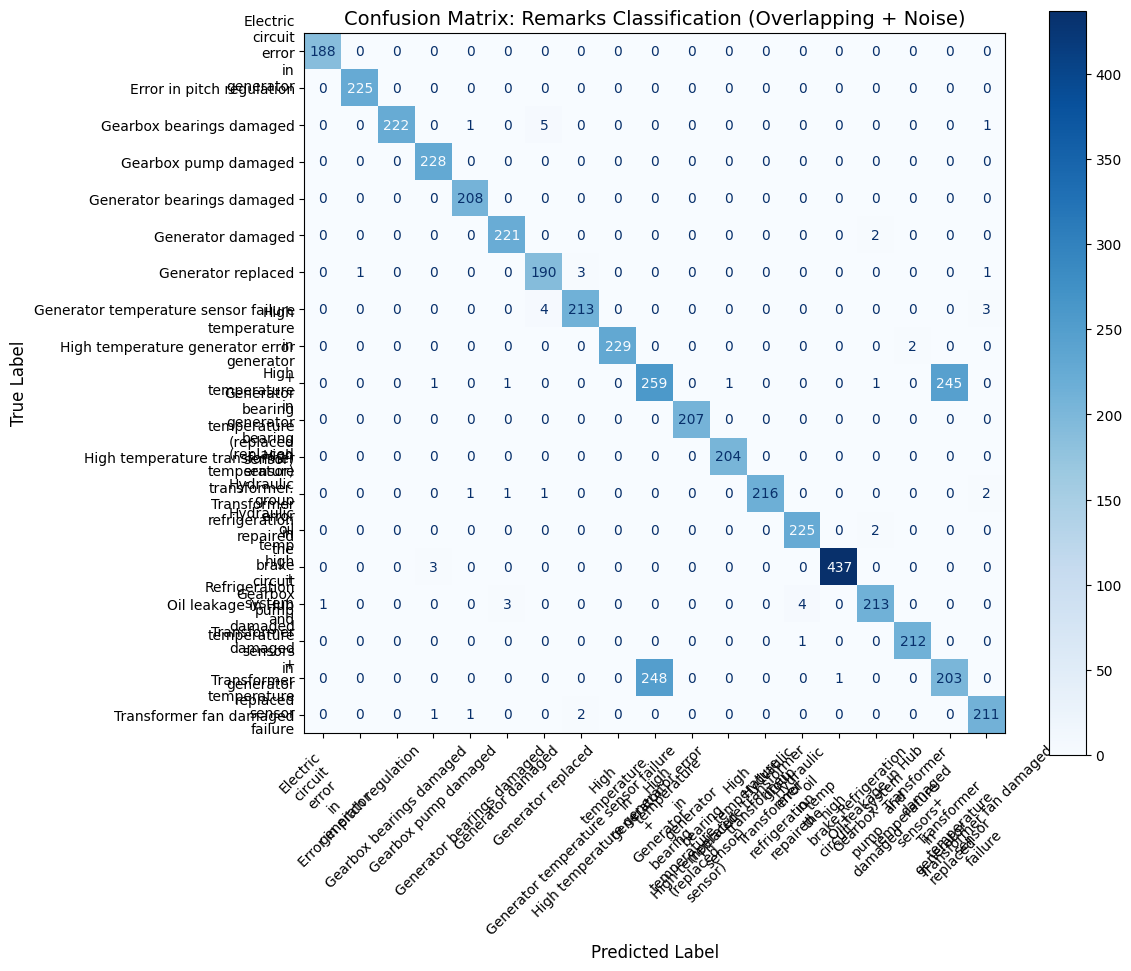

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# --- Preprocessing ---
# Drop any rows with missing remarks
data = synthetic_data.dropna(subset=['Remarks']).copy()

# Separate features and labels
X = data.drop(columns=['Fault_Flag', 'Remarks'])
X = X.select_dtypes(include=[np.number])
y = data['Remarks']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# --- Train Random Forest Classifier ---
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

# --- Predict and Evaluate ---
y_pred = rf.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 10))

# Optional: Shorten or wrap long labels for display
wrapped_labels = ['\n'.join(label.split()) if len(label.split()) > 4 else label for label in le.classes_]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=wrapped_labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)

plt.title("Confusion Matrix: Remarks Classification (Overlapping + Noise)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X_scaled, y_encoded, cv=5)
print(f"Cross-Validation Accuracy (5-Fold): {scores.mean():.2f} ± {scores.std():.2f}")
